In [1]:
import numpy as np
import tqdm
import torch 
import torch.nn.functional as func

import misc.faust as faust
import models

FAUST = "../../Downloads/Mesh-Datasets/MyFaustDataset"
MODEL_PATH = "../model_data/data.pt"

dataset = faust.FaustDataset(FAUST)

model = models.ChebClassifier(
    param_conv_layers=[64,64,32,32],
    E_t=dataset.downscaled_edges, 
    D_t=dataset.downscale_matrices,
    num_classes = 10)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
model.load_state_dict(torch.load(MODEL_PATH))


<All keys matched successfully>

In [2]:
import plotly
import plotly.io as pio
import plotly.graph_objects as go

def visualize(mesh, D=None, F=None, scale_index=0, intensity=None):
    """
    visualize input mesh.
    
    The input lists D and F are respectively the downscale matrices and the faces of the downscaled
    mesh. The scale_index parameter indicates which downscaling matrix should be used, if scale_index=0 then
    no downscaling is applied (scale_index must be less then or equal to the length of D and F).
    
    NOTE: if scale_index is 0 then the parameters F and D are not necessary and can simply have value to None.
    """
    
    pos = mesh.pos.numpy()
    if scale_index == 0:
        f = mesh.face.numpy()
    else:
        f = F[scale_index-1]
        for j in range(scale_index):
            pos = torch.sparse.mm(D[j], pos) #transform graph signal (vertex positions) to downscaled graph

    if intensity is None:
        intensity = np.ones(pos.shape[0])
    
    x,y,z = pos[:,0], pos[:,1], pos[:,2]
    i,j,k = f[0,:], f[1,:], f[2,:]
    mesh = go.Mesh3d(x=x, y=z, z=y,
              color='lightpink',
              intensity=intensity,
              opacity=1,
              i=i, j=j, k=k,
              showscale=True)
    layout = go.Layout(scene=go.layout.Scene(aspectmode="data")) 

    #pio.renderers.default="plotly_mimetype"
    fig = go.Figure(data=[mesh],
                   layout=layout)
    fig.update_layout(
        autosize=True,
        margin=dict(l=20, r=20, t=20, b=20),
        paper_bgcolor="LightSteelBlue")
    fig.show()
    

now that we have defined the visualization procedure, we can show some meshes:

In [ ]:
from torch_geometric.data import Data
import interpretability as intr

#visualize(avg_mesh)
mesh = dataset[99]
per = torch.rand_like(mesh.pos)*30
impact = intr.compute_impact(mesh.pos, f=lambda x: model(x), perturbed_pos=per, num_samples=15000)

In [ ]:
intensity = impact.detach().numpy()
visualize(mesh, intensity=intensity)

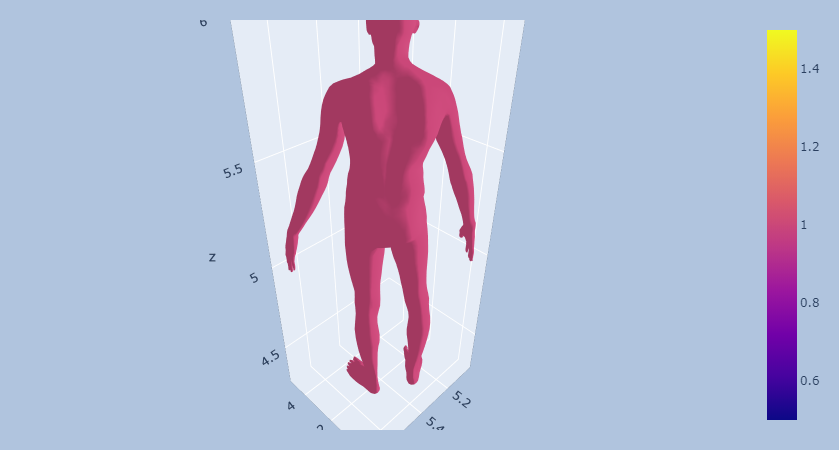

In [7]:
mesh = dataset[0]
x = mesh.pos.clone()
faust.transform_rotation_(mesh.pos)
faust.transform_position_(mesh.pos,5,2.5)
visualize(mesh)